# Применение нейросетей в криптотрейдинге
Автор: Николаев О.В.

**Проект для курса NLP AIM 2024**

**Мотивация**

Задача проекта - построить модель классификации, способную предсказывать поведение криптовалюты на бирже. А именно, уметь предугадывать, с `precision > 0.5` (и не сильно низким `recall`) куда на следующем шаге пойдет цена.

Данная способность предугадывать способна принести финансовую выгоду, т.к. мы можем вовремя продавать либо покупать криптомонету. 


Т.к. наши данные представляют из себя последовательность данных (timeseries dataset), то разумным представляется попробовать два подхода.

1) Модель с LSTM
2) Модель на основе Transformer

Для себя, я выделил основополагающие аспекты криптотрейдинга:
1) Крипта будет расти (на повышающемся тренде есть смысл торговать) 
2) Пока поведение цены криптомонеты не стало белым шумом, мы сможем делать ML модели, которые будут работать в плюс  
3) Мы учитываем риск катаклизма, т.к. торгуем в короткую
4) На понижающемся тренде выходить в плюс, на повышающемся не отставать от купил-забыл

В качестве крипто пары выбран USD-BTC (цена биткойна в долларах). Для обучения и тестирования моделей использовалиь исторические данные торгов с 2018 года.

---

Истоник данных - https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data

Источники:
1) https://sbersova.ru/sections/invest/indikatory-v-tekhanalize?utm_source=digest&utm_medium=invst#3
2) https://b2broker.com/ru/news/the-best-trend-indicators-for-trading-in-2023/
3) https://github.com/ta-lib/ta-lib-python
4) https://howtotrade.com/indicators/stochastic-rsi-indicator/
5) https://tradesanta.com/blog/best-crypto-indicators-rsi-stochastic-rsi

In [1]:
from time import time, sleep
from tqdm import tqdm
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_classif
import seaborn as sns


import talib as ta
### !pip install TA_Lib-0.4.32-cp311-cp311-win_amd64.whl


import zipfile
import os

os.chdir('.')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve

import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import EarlyStopping
from torch.nn import functional as F
from transformers import get_scheduler

# Data preparation




```python
with zipfile.ZipFile("data/btcusd_1-min_data_2024_12_19.zip", 'r') as zip_ref:
    zip_ref.extractall("data/")
```

In [2]:
data_full = pd.read_csv("data/btcusd_1-min_data.csv")
data_full = data_full.rename(columns={"Timestamp": "Datetime"})
data_full["Datetime"] = pd.to_datetime(data_full['Datetime'], unit='s')
data_full = data_full.set_index("Datetime")

In [3]:
# будем анализировать относительно новые данные
data_full = data_full[data_full.index >= '2018-01-01']

In [4]:
data_full

,Open,High,Low,Close,Volume
Datetime,,,,,
2018-01-01 00:00:00,13840.53,13840.53,13819.04,13820.96,1.045522
2018-01-01 00:01:00,13821.05,13888.90,13821.05,13850.67,18.083867
2018-01-01 00:02:00,13888.91,13938.63,13850.01,13850.40,3.553685
2018-01-01 00:03:00,13850.40,13933.94,13850.40,13894.25,0.894357
2018-01-01 00:04:00,13894.26,13978.24,13879.83,13880.45,11.214208
...,...,...,...,...,...
2024-12-17 23:56:00,106107.00,106226.00,106107.00,106220.00,3.361950
2024-12-17 23:57:00,106246.00,106246.00,106179.00,106179.00,0.895926
2024-12-17 23:58:00,106150.00,106150.00,106149.00,106149.00,0.265341


In [5]:
# в данных нет пропусков
data_full.isnull().mean().round(4) * 100

Open      0.0
High      0.0
Low       0.0
Close     0.0
Volume    0.0
dtype: float64

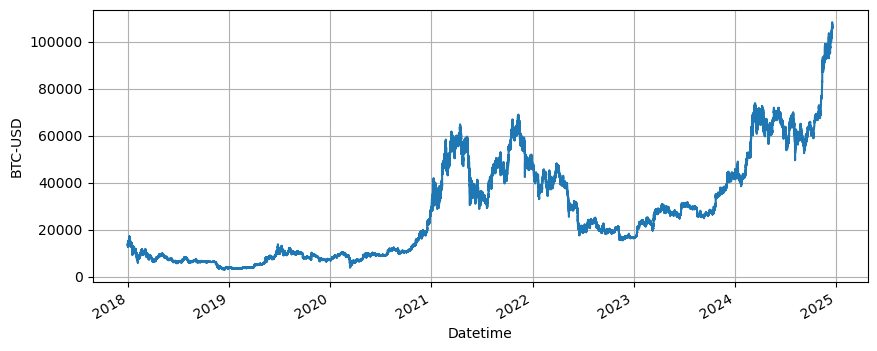

In [6]:
data_full['Close'].plot(figsize=(10, 4))
plt.ylabel('BTC-USD')
plt.grid()
plt.show()

## Resample и формирование target

1 - цена возрастет на следующем тике

0 - цена упадет на следующем тике

In [7]:
data = data_full.resample('h').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}).dropna()

In [8]:
data['target'] = (data['Close'].shift(-1) > data['Close']).astype(int)

In [14]:
data.head(3)

,Open,High,Low,Close,Volume,target
Datetime,,,,,,
2018-01-01 00:00:00,13840.53,14049.78,13804.25,13949.61,207.963504,1
2018-01-01 01:00:00,13949.65,14296.06,13948.95,14111.28,362.943308,0
2018-01-01 02:00:00,14111.20,14166.00,13944.64,13977.47,263.540150,0


### Features

Признаки представляют из себя `технически индексы`, которые были созданы экономистами (описание см. в источниках)

In [15]:
from talib import (
    RSI, MACD, CCI, DX, SAR, ADX, ADXR, APO, AROONOSC, BOP, CMO, MFI, MINUS_DI, MINUS_DM, MOM, PLUS_DI, PLUS_DM, PPO, 
    ROC, ROCP, ROCR, ROCR100, TRIX, ULTOSC, WILLR, AD, ADOSC, OBV, HT_DCPERIOD, HT_DCPHASE, HT_SINE, HT_TRENDMODE
)

In [16]:
def get_features_for_each_coin(data):
    data_with_features = data.copy()
    data_with_features['rsi'] = RSI(data_with_features['Close'], timeperiod=14)
    data_with_features['macd'], data_with_features['macd_signal'], data_with_features['macd_hist'] = MACD(data_with_features['Close'], fastperiod=12,
                                                                    slowperiod=26, signalperiod=9)
    data_with_features['cci'] = CCI(data_with_features['High'], data_with_features['Low'], data_with_features['Close'], timeperiod=14)
    data_with_features['dx'] = DX(data_with_features['High'], data_with_features['Low'], data_with_features['Close'], timeperiod=14)

    # Overlap studies
    data_with_features['sar'] = SAR(data_with_features['High'], data_with_features['Low'], acceleration=0., maximum=0.)

    # Added momentum indicators
    data_with_features['adx'] = ADX(data_with_features['High'], data_with_features['Low'], data_with_features['Close'])
    data_with_features['adxr'] = ADXR(data_with_features['High'], data_with_features['Low'], data_with_features['Close'])
    data_with_features['apo'] = APO(data_with_features['Close'])
    data_with_features['aroonosc'] = AROONOSC(data_with_features['High'], data_with_features['Low'])
    data_with_features['bop'] = BOP(data_with_features['Open'], data_with_features['High'], data_with_features['Low'], data_with_features['Close'])
    data_with_features['cmo'] = CMO(data_with_features['Close'])
    data_with_features['mfi'] = MFI(data_with_features['High'], data_with_features['Low'], data_with_features['Close'],data_with_features['Volume'])
    data_with_features['minus_di'] = MINUS_DI(data_with_features['High'], data_with_features['Low'], data_with_features['Close'])
    data_with_features['minus_dm'] = MINUS_DM(data_with_features['High'], data_with_features['Low'])
    data_with_features['mom'] = MOM(data_with_features['Close'])
    data_with_features['plus_di'] = PLUS_DI(data_with_features['High'], data_with_features['Low'], data_with_features['Close'])
    data_with_features['plus_dm'] = PLUS_DM(data_with_features['High'], data_with_features['Low'])
    data_with_features['ppo_ta'] = PPO(data_with_features['Close'])
    data_with_features['roc'] = ROC(data_with_features['Close'])
    data_with_features['rocp'] = ROCP(data_with_features['Close'])
    data_with_features['rocr'] = ROCR(data_with_features['Close'])
    data_with_features['rocr100'] = ROCR100(data_with_features['Close'])
    data_with_features['trix'] = TRIX(data_with_features['Close'])
    data_with_features['ultosc'] = ULTOSC(data_with_features['High'], data_with_features['Low'], data_with_features['Close'])
    data_with_features['willr'] = WILLR(data_with_features['High'], data_with_features['Low'], data_with_features['Close'])

    # Volatility Indicators
    data_with_features['ad'] = AD(data_with_features['High'], data_with_features['Low'], data_with_features['Close'],data_with_features['Volume'])
    data_with_features['adosc'] = ADOSC(data_with_features['High'], data_with_features['Low'], data_with_features['Close'],data_with_features['Volume'], fastperiod=3, slowperiod=10)
    data_with_features['obv'] = OBV(data_with_features['Close'],data_with_features['Volume'])

    # Cycle indicator functions
    data_with_features['roc'] = HT_DCPERIOD(data_with_features['Close'])
    data_with_features['ht_dcphase'] = HT_DCPHASE(data_with_features['Close'])
    data_with_features['ht_sine'], _ = HT_SINE(data_with_features['Close'])
    data_with_features['ht_trendmode'] = HT_TRENDMODE(data_with_features['Close'])

    return data_with_features

In [17]:
start = time()

data_with_features = get_features_for_each_coin(data)

print(time() - start, 's')

0.13303923606872559 s


In [30]:
data_with_features.head(3)

,Open,High,Low,Close,Volume,target,rsi,macd,macd_signal,macd_hist,...,rocr100,trix,ultosc,willr,ad,adosc,obv,ht_dcphase,ht_sine,ht_trendmode
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-04 16:00:00,14418.95,14605.00,14335.42,14567.81,334.684868,0,44.839131,-57.714743,30.858168,-88.572911,...,94.903929,0.179213,39.465497,-69.671217,-2739.117990,-545.858151,-2890.179601,307.389089,-0.794530,1
2018-01-04 17:00:00,14566.56,14605.00,14258.60,14400.04,572.110339,1,41.481751,-79.518475,8.782839,-88.301314,...,94.426492,0.171262,40.098174,-83.224008,-2844.026907,-486.397043,-3462.289940,-30.813759,-0.512249,1
2018-01-04 18:00:00,14413.66,14653.78,14400.00,14575.48,566.761419,1,46.032420,-81.699764,-9.313681,-72.386083,...,96.744963,0.163273,43.849045,-69.051620,-2626.996902,-348.799129,-2895.528521,-15.339474,-0.264538,1


## Отсев скоррелированых признаков

С помощью `Mutual Information` можно найти очень сложные зависимости (не линейные) между переменными, ибо под собой, MI имеет оценку взаимной энтропии 

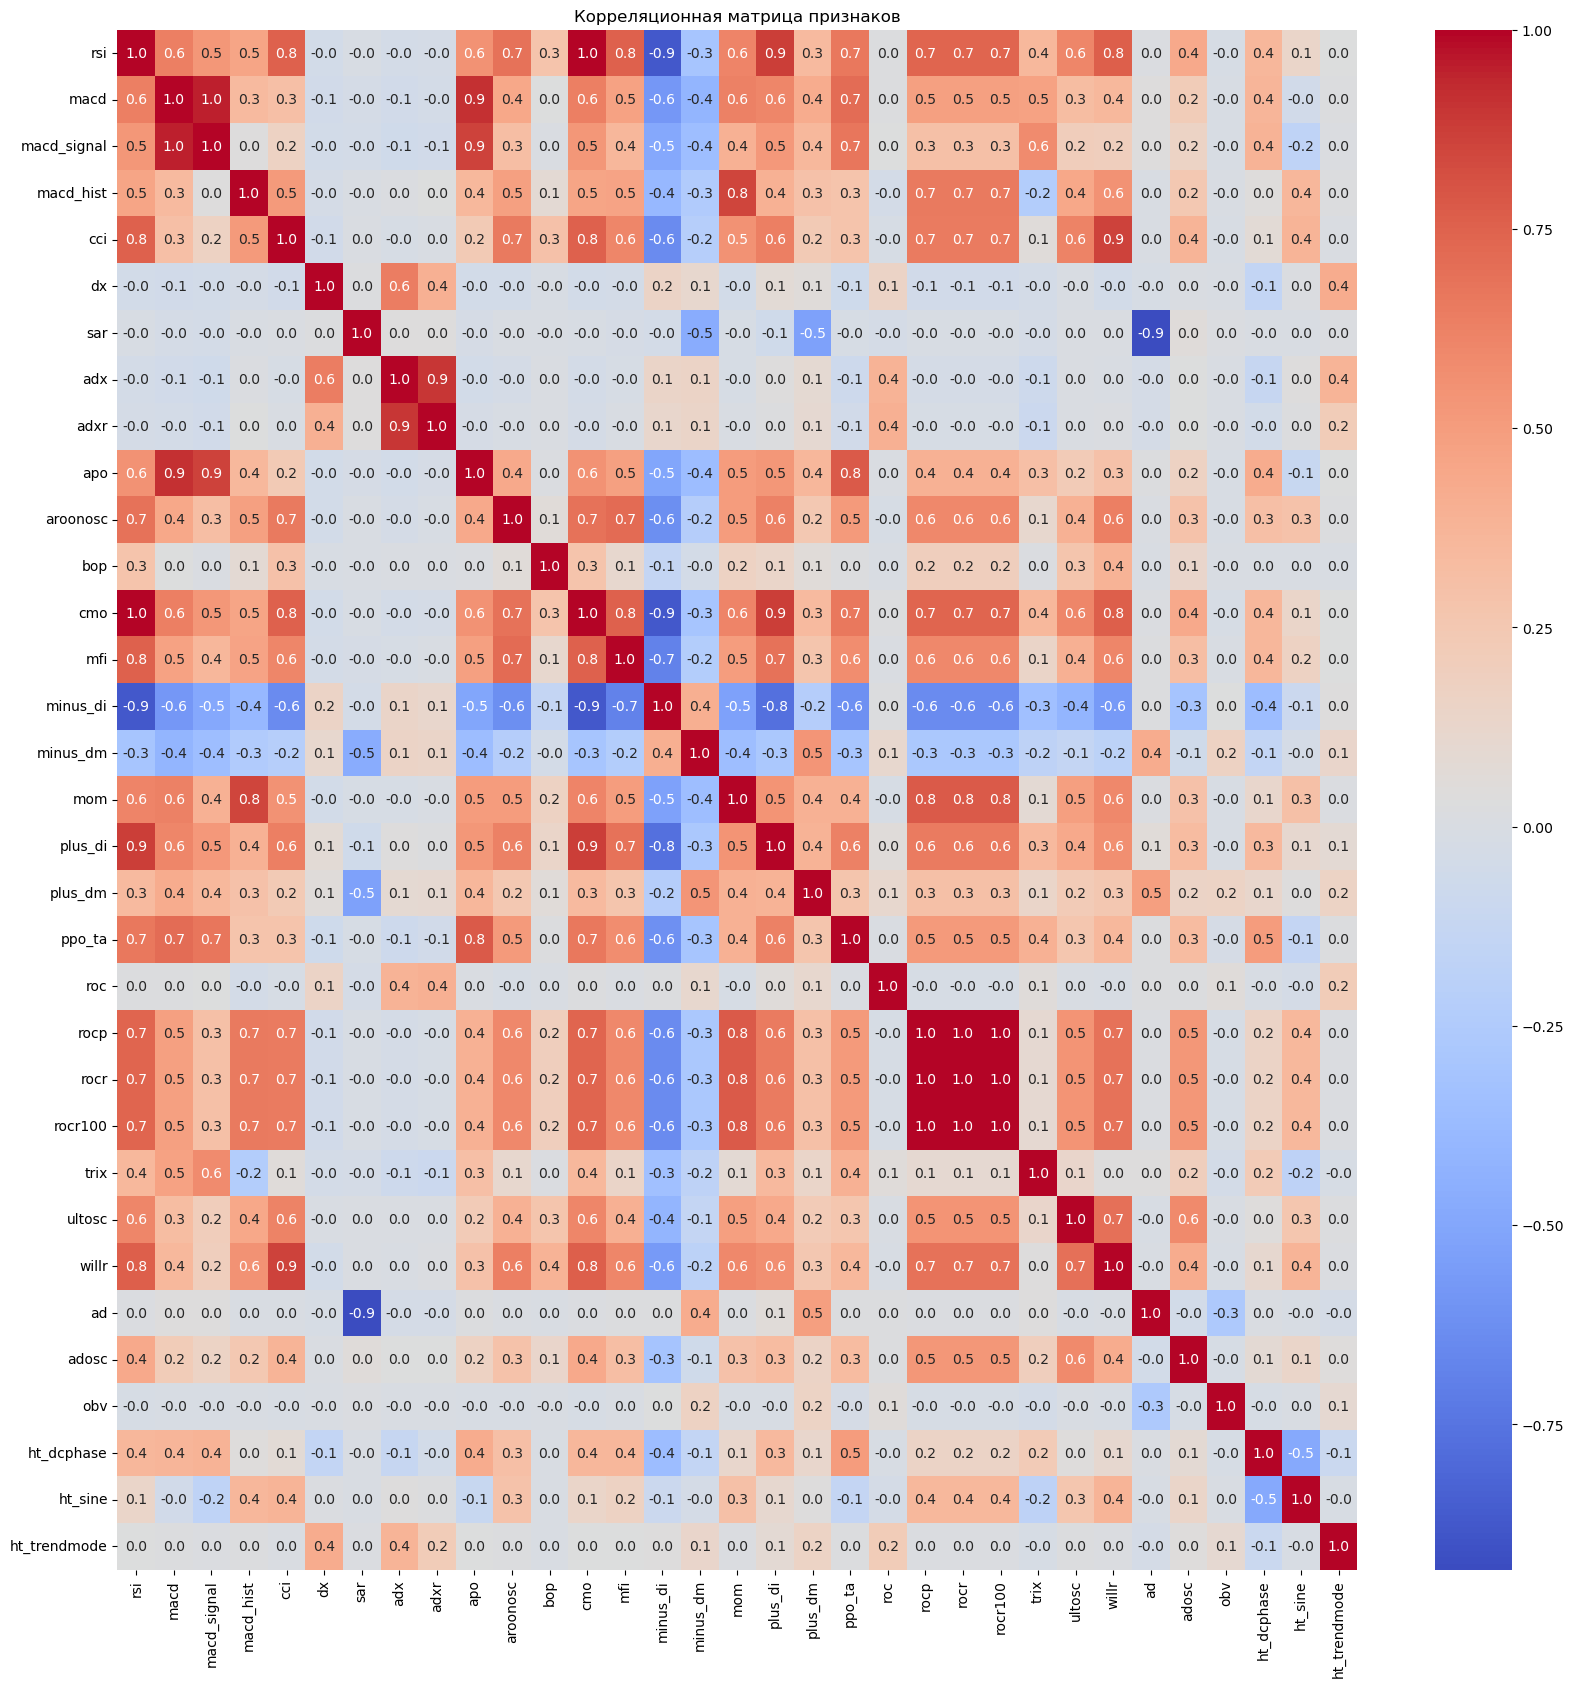

Удалено признаков 6: {'cmo', 'macd_signal', 'ad', 'rocr', 'apo', 'rocr100'}


In [26]:
data_with_features = data_with_features.dropna()

# Выделим признаки и целевую переменную
X = data_with_features.drop(columns=['target', 'Open', 'High', 'Low', 'Close', 'Volume'])
y = data_with_features['target']

# Рассчитаем Mutual Information
mi = mutual_info_classif(X, y)
mi_df = pd.Series(mi, index=X.columns).sort_values(ascending=False)

# Построим heatmap корреляции
corr_matrix = X.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title("Корреляционная матрица признаков")
plt.show()

# Удалим признаки с высокой корреляцией
threshold = 0.9
corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            corr_features.add(colname)

# Удалим скоррелированные признаки
# X_filtered = X.drop(columns=corr_features)
print(f"Удалено признаков {len(corr_features)}: {corr_features}")

In [32]:
df = data_with_features.drop(columns=corr_features)
df

,Open,High,Low,Close,Volume,target,rsi,macd,macd_hist,cci,...,roc,rocp,trix,ultosc,willr,adosc,obv,ht_dcphase,ht_sine,ht_trendmode
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-04 16:00:00,14418.95,14605.00,14335.42,14567.81,334.684868,0,44.839131,-57.714743,-88.572911,-108.215793,...,15.313593,-0.050961,0.179213,39.465497,-69.671217,-545.858151,-2890.179601,307.389089,-0.794530,1
2018-01-04 17:00:00,14566.56,14605.00,14258.60,14400.04,572.110339,1,41.481751,-79.518475,-88.301314,-105.633121,...,15.141818,-0.055735,0.171262,40.098174,-83.224008,-486.397043,-3462.289940,-30.813759,-0.512249,1
2018-01-04 18:00:00,14413.66,14653.78,14400.00,14575.48,566.761419,1,46.032420,-81.699764,-72.386083,-63.468361,...,14.995583,-0.032550,0.163273,43.849045,-69.051620,-348.799129,-2895.528521,-15.339474,-0.264538,1
2018-01-04 19:00:00,14600.21,14765.84,14509.70,14641.10,542.791910,0,47.671552,-77.243056,-54.343500,-33.453305,...,14.924269,-0.017678,0.155429,44.395238,-63.750707,-256.309450,-2352.736611,-0.689643,-0.012036,1
2018-01-04 20:00:00,14641.01,14716.69,14500.00,14551.29,766.083186,0,45.628901,-80.035400,-45.708676,-38.093494,...,15.015445,-0.023473,0.147590,48.342818,-71.005736,-323.533801,-3118.819796,14.313986,0.247236,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-17 20:00:00,106464.00,106879.00,106151.00,106713.00,65.299013,0,59.894085,1096.506577,-168.815941,-113.440019,...,23.039102,-0.004645,0.111287,57.931108,-62.704140,49.245051,-143014.063070,206.421471,-0.444971,1
2024-12-17 21:00:00,106717.00,106795.00,106252.00,106490.00,41.462692,0,57.892533,1005.703316,-207.695363,-113.388465,...,22.716343,-0.003313,0.113022,51.838732,-71.173566,41.815342,-143055.525762,215.255599,-0.577225,1
2024-12-17 22:00:00,106314.00,106394.00,105363.00,105976.00,96.132544,1,53.458090,882.097303,-265.041100,-195.339984,...,22.559489,-0.010855,0.114229,56.358834,-79.573476,40.759766,-143151.658305,224.770301,-0.704266,1


In [33]:
# save df
df.to_csv("data/df_v1.csv")

In [2]:
df = pd.read_csv("data/df_v1.csv", index_col="Datetime")

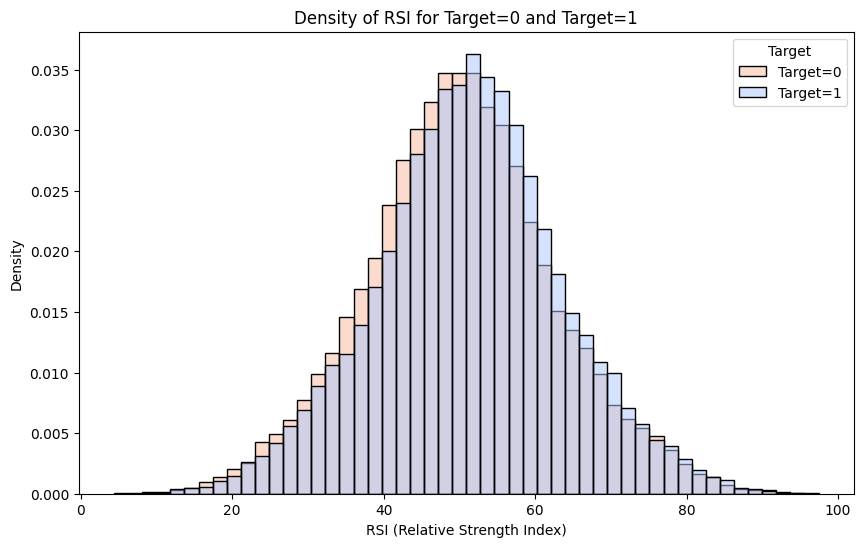

In [3]:
plt.figure(figsize=(10, 6))
sns.histplot(x="rsi", hue="target", data=df, bins=50, kde=False, stat="density", common_norm=False, palette="coolwarm")


plt.xlabel("RSI")
plt.ylabel("Density")
plt.title("Density of RSI for Target=0 and Target=1")
plt.legend(title="Target", labels=["Target=0", "Target=1"], loc="upper right")

# Show the plot
plt.show()

# LSTM based модель

In [13]:
def prepare_data(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)
        y.append(target.iloc[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 12
X_lstm, y_lstm = prepare_data(df.drop(columns=["target"]), df["target"], seq_length)


# Вариант разделения №1
# Разделим данные на тренировочную и валидационную выборки
# train_size = int(len(X_lstm) * 0.8)
# X_train, X_val = X_lstm[:train_size], X_lstm[train_size:]
# y_train, y_val = y_lstm[:train_size], y_lstm[train_size:]

# Вариант разделения №2
X_train, y_train = [], []
X_val, y_val = [], []
for i in range(0, len(X_lstm), 6):  # 6 = 5 training + 1 validation
    if i + 5 < len(X_lstm):
        X_train.extend(X_lstm[i:i+5])
        y_train.extend(y_lstm[i:i+5])
    if i + 6 < len(X_lstm):
        X_val.append(X_lstm[i+5])
        y_val.append(y_lstm[i+5])

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)


# Преобразуем данные в тензоры
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

# Создаем DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4)

In [61]:
class LSTMClassifier(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.2):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        # self.fc2 = nn.Linear(hidden_size, output_size)
        #
        self.train_losses = []
        self.val_losses = []


    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :] 
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat.squeeze(), y.squeeze())
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat.squeeze(), y.squeeze())
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.val_losses.append(loss.item())
        return loss

    def configure_optimizers(self): 
        optimizer = optim.AdamW(self.parameters(), lr=3e-4) # 3e-4 # 1e-5
        scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0.05*len(train_loader) * N_EPOCHS, num_training_steps=len(train_loader) * N_EPOCHS)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },
        }

    def plot_losses(self):
        fig, axes = plt.subplots(1, 2, figsize=(20, 6))
        axes[0].plot(self.train_losses, label='Training Loss', linestyle='--')
        axes[0].set_xlabel('Step')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training Loss')
        axes[0].legend()
        axes[1].plot(self.val_losses, label='Validation Loss', linestyle='--', c='orange')
        axes[1].set_xlabel('Step')
        axes[1].set_ylabel('Loss')
        axes[1].set_title('Validation Loss')
        axes[1].legend()
        plt.tight_layout()
        plt.show()

In [62]:
N_EPOCHS = 20


# Параметры модели
input_size = X_train.shape[2]
hidden_size = 128
num_layers = 2
output_size = 1
dropout_rate = 0.2


model = LSTMClassifier(input_size, hidden_size, num_layers, output_size, dropout_rate)


def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

LSTMClassifier(
  (lstm): LSTM(32, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [63]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

223361


In [64]:
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    verbose=True,
    mode='min'
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | lstm | LSTM   | 215 K  | train
1 | fc1  | Linear | 8.3 K  | train
2 | relu | ReLU   | 0      | train
3 | fc2  | Linear | 65     | train
----------------------------------------
223 K     Trainable params
0         Non-trainable params
223 K     Total params
0.893     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.704


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.702


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.698


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.695


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.694


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.694. Signaling Trainer to stop.


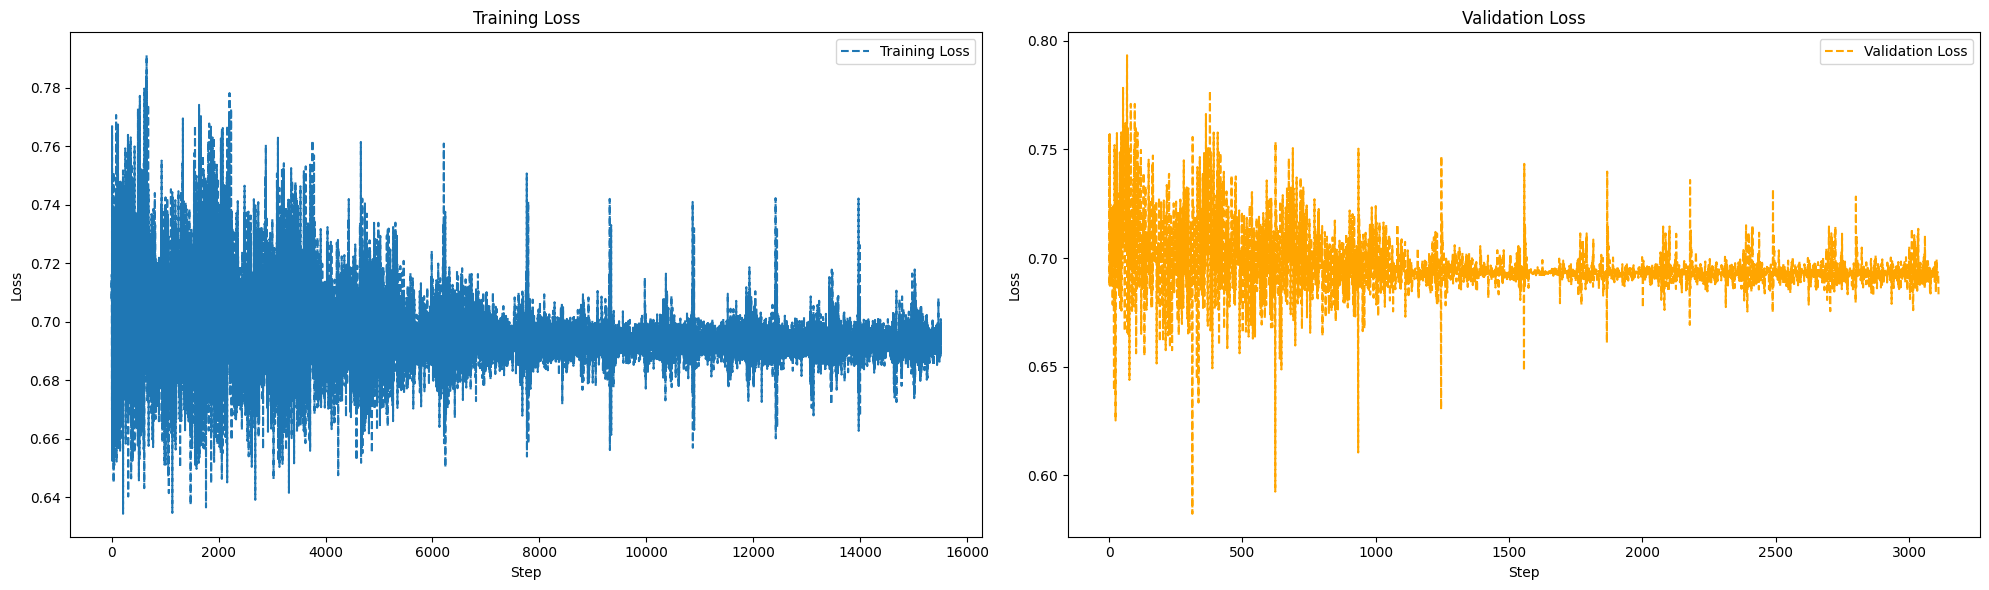

In [65]:
# Обучение модели
trainer = pl.Trainer(
    max_epochs=N_EPOCHS, 
    check_val_every_n_epoch=1,
    callbacks=[early_stop_callback])
trainer.fit(model, train_loader, val_loader)
model.plot_losses()

In [66]:
# Предсказания на обучающей выборке
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor)
    y_train_pred_proba = torch.sigmoid(y_train_pred).numpy()

# ROC AUC
roc_auc = roc_auc_score(y_train, y_train_pred_proba)
print(f"ROC AUC: {roc_auc}")

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_train, y_train_pred_proba)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc}")


# Найдем макисмальный precition
filtered_precision = precision[recall > 0.05]
filtered_recall = recall[recall > 0.05]
max_precision = filtered_precision.max()
max_precision_index = filtered_precision.argmax()
recall_at_max_precision = filtered_recall[max_precision_index]
print(f"Maximum Precision (Recall > 0.1): {max_precision:.4f}")
print(f"Recall at Maximum Precision: {recall_at_max_precision:.4f}")

ROC AUC: 0.5050813282349558
Precision-Recall AUC: 0.5106662068442402
Maximum Precision (Recall > 0.1): 0.5147
Recall at Maximum Precision: 0.4030


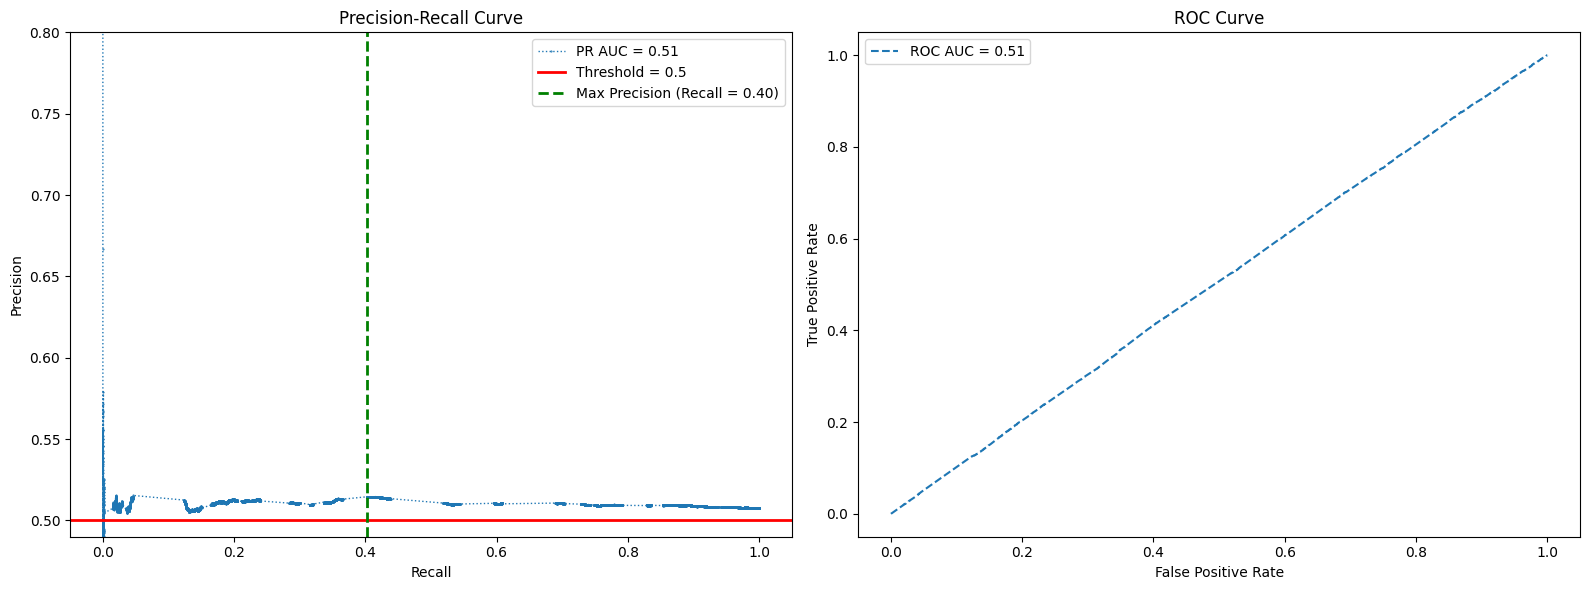

In [67]:
# Визуализация
plt.figure(figsize=(16, 6))

# Subplot 1: Precision-Recall Curve
plt.subplot(1, 2, 1)
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.2f}", marker='o', markersize=0.5, linestyle = ':', linewidth=1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim(0.49, 0.8)
plt.axhline(y=0.5, color='r', linestyle='-', linewidth=2, label="Threshold = 0.5")  # Horizontal line at y=0.5
plt.axvline(x=recall_at_max_precision, color='g', linestyle='--', linewidth=2, label=f"Max Precision (Recall = {recall_at_max_precision:.2f})")  # Vertical line at max precision
plt.title("Precision-Recall Curve")
plt.legend()

# Subplot 2: ROC Curve
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_train, y_train_pred_proba)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}", linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [68]:
# Предсказания на валидационной выборке
model.eval()
with torch.no_grad():
    y_val_pred = model(X_val_tensor)
    y_val_pred_proba = torch.sigmoid(y_val_pred).numpy()

# ROC AUC
roc_auc = roc_auc_score(y_val, y_val_pred_proba)
print(f"ROC AUC: {roc_auc}")

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_val, y_val_pred_proba)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc}")

# Найдем макисмальный precition
filtered_precision = precision[recall > 0.05]
filtered_recall = recall[recall > 0.05]
max_precision = filtered_precision.max()
max_precision_index = filtered_precision.argmax()
recall_at_max_precision = filtered_recall[max_precision_index]
print(f"Maximum Precision (Recall > 0.1): {max_precision:.4f}")
print(f"Recall at Maximum Precision: {recall_at_max_precision:.4f}")

ROC AUC: 0.4961450907213135
Precision-Recall AUC: 0.5053857974785148
Maximum Precision (Recall > 0.1): 0.5076
Recall at Maximum Precision: 0.6987


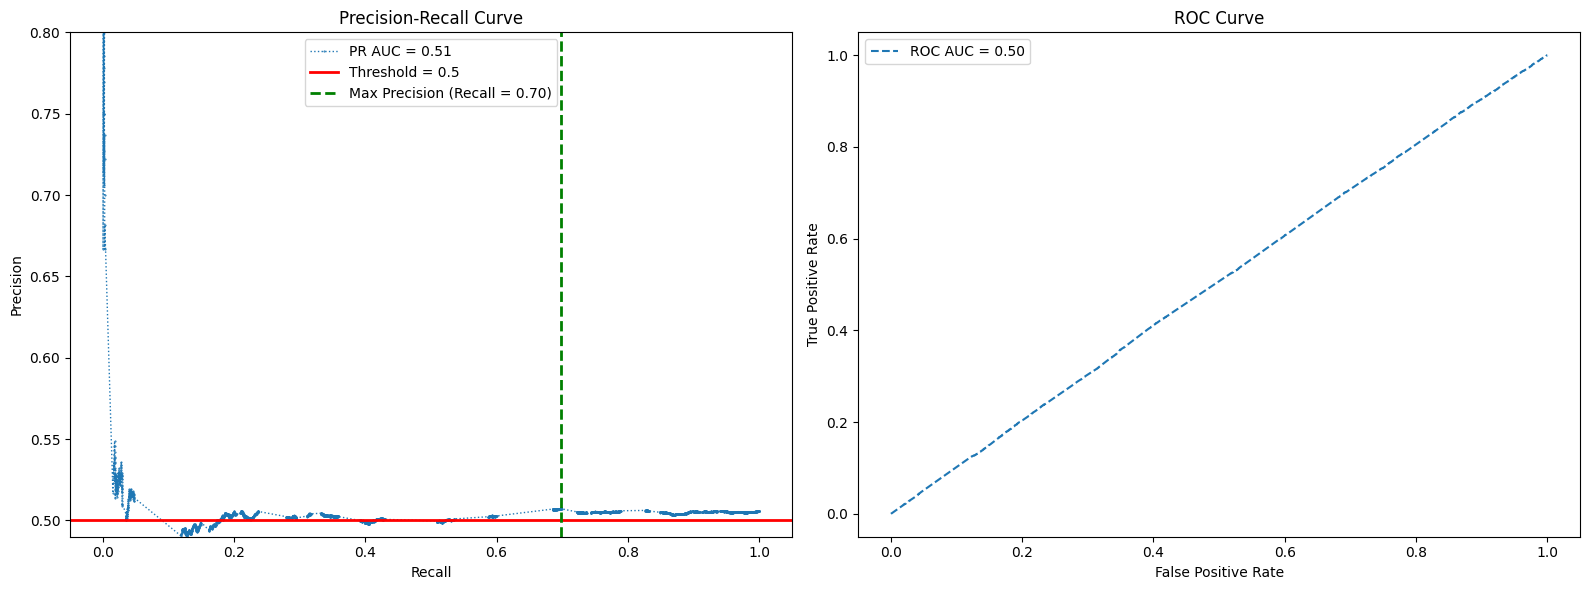

In [69]:
# Визуализация
plt.figure(figsize=(16, 6))

# Subplot 1: Precision-Recall Curve
plt.subplot(1, 2, 1)
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.2f}", marker='o', markersize=0.5, linestyle = ':', linewidth=1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim(0.49, 0.8)
plt.axhline(y=0.5, color='r', linestyle='-', linewidth=2, label="Threshold = 0.5")  # Horizontal line at y=0.5
plt.axvline(x=recall_at_max_precision, color='g', linestyle='--', linewidth=2, label=f"Max Precision (Recall = {recall_at_max_precision:.2f})")  # Vertical line at max precision
plt.title("Precision-Recall Curve")
plt.legend()

# Subplot 2: ROC Curve
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_train, y_train_pred_proba)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}", linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

# Transformer based model

In [18]:
class TransformerClassifier(pl.LightningModule):
    def __init__(self, input_size, d_model, nhead, num_layers, dim_feedforward, output_size, dropout=0.2):
        super(TransformerClassifier, self).__init__()
        self.d_model = d_model
        self.input_embedding = nn.Linear(input_size, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 1000, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, output_size)
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        seq_len = x.size(1)
        x = self.input_embedding(x) + self.positional_encoding[:, :seq_len, :]
        x = self.transformer_encoder(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat.squeeze(), y.squeeze())
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat.squeeze(), y.squeeze())
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.val_losses.append(loss.item())
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-5) # 3e-4
        scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0.05*len(train_loader) * N_EPOCHS, num_training_steps=len(train_loader) * N_EPOCHS)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },
        }

    def plot_losses(self):
        fig, axes = plt.subplots(1, 2, figsize=(20, 6))
        axes[0].plot(self.train_losses, label='Training Loss', linestyle='--')
        axes[0].set_xlabel('Step')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training Loss')
        axes[0].legend()
        axes[1].plot(self.val_losses, label='Validation Loss', linestyle='--',  c='orange')
        axes[1].set_xlabel('Step')
        axes[1].set_ylabel('Loss')
        axes[1].set_title('Validation Loss')
        axes[1].legend()
        plt.tight_layout()
        plt.show()

In [26]:
N_EPOCHS = 20

input_size = X_train.shape[2]
d_model = 256
nhead = 8
num_layers = 4
dim_feedforward = 512
output_size = 1
dropout = 0.2


model = TransformerClassifier(
    input_size=input_size,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    output_size=output_size,
    dropout=dropout
)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

2373121


In [27]:
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    verbose=True,
    mode='min'
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | input_embedding     | Linear             | 8.4 K  | train
1 | transformer_encoder | TransformerEncoder | 2.1 M  | train
2 | fc                  | Linear             | 257    | train
3 | loss_fn             | BCEWithLogitsLoss  | 0      | train
  | other params        | n/a                | 256 K  | n/a  
-------------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.492     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.729


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.721


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.710


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.701


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.696


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.695


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.694


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.694. Signaling Trainer to stop.


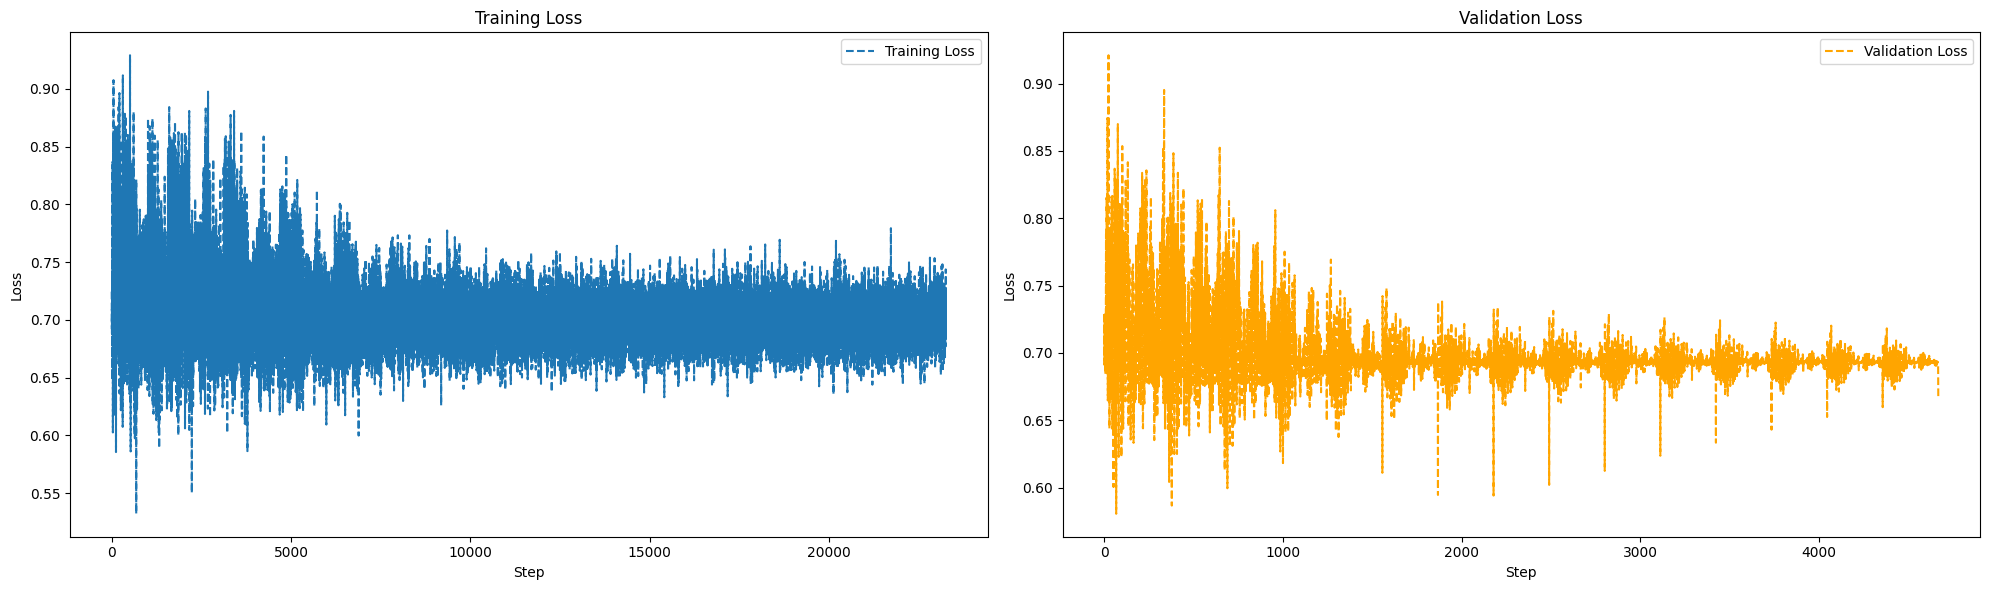

In [28]:
# Обучение модели
trainer = pl.Trainer(
    max_epochs=N_EPOCHS, 
    check_val_every_n_epoch=1,
    callbacks=[early_stop_callback])
trainer.fit(model, train_loader, val_loader)
model.plot_losses()

In [29]:
# Предсказания на обучающей выборке
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor)
    y_train_pred_proba = torch.sigmoid(y_train_pred).numpy()

# ROC AUC
roc_auc = roc_auc_score(y_train, y_train_pred_proba)
print(f"ROC AUC: {roc_auc}")

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_train, y_train_pred_proba)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc}")


# Найдем макисмальный precition
filtered_precision = precision[recall > 0.05]
filtered_recall = recall[recall > 0.05]
max_precision = filtered_precision.max()
max_precision_index = filtered_precision.argmax()
recall_at_max_precision = filtered_recall[max_precision_index]
print(f"Maximum Precision (Recall > 0.1): {max_precision:.4f}")
print(f"Recall at Maximum Precision: {recall_at_max_precision:.4f}")

ROC AUC: 0.4981857481699722
Precision-Recall AUC: 0.5046114929049659
Maximum Precision (Recall > 0.1): 0.5086
Recall at Maximum Precision: 0.9463


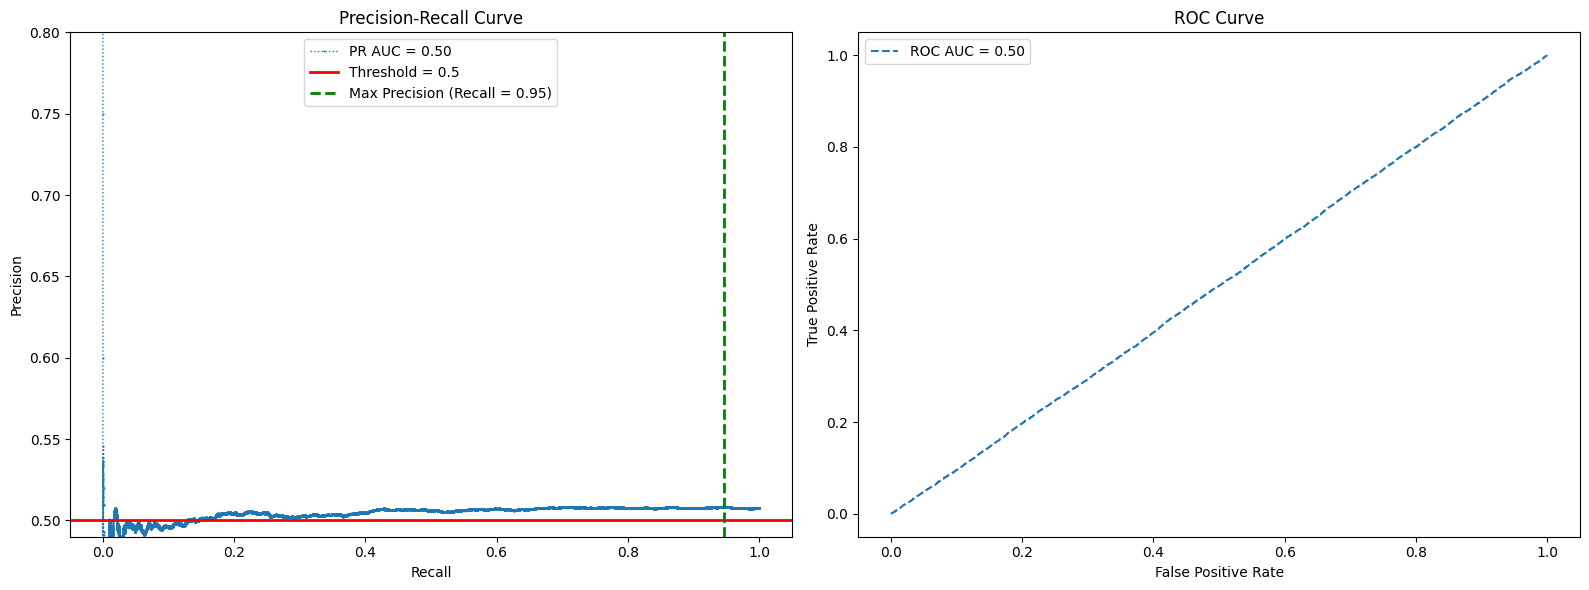

In [30]:
# Визуализация
plt.figure(figsize=(16, 6))

# Subplot 1: Precision-Recall Curve
plt.subplot(1, 2, 1)
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.2f}", marker='o', markersize=0.5, linestyle = ':', linewidth=1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim(0.49, 0.8)
plt.axhline(y=0.5, color='r', linestyle='-', linewidth=2, label="Threshold = 0.5")  # Horizontal line at y=0.5
plt.axvline(x=recall_at_max_precision, color='g', linestyle='--', linewidth=2, label=f"Max Precision (Recall = {recall_at_max_precision:.2f})")  # Vertical line at max precision
plt.title("Precision-Recall Curve")
plt.legend()

# Subplot 2: ROC Curve
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_train, y_train_pred_proba)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}", linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [31]:
# Предсказания на валидационной выборке
model.eval()
with torch.no_grad():
    y_val_pred = model(X_val_tensor)
    y_val_pred_proba = torch.sigmoid(y_val_pred).numpy()

# ROC AUC
roc_auc = roc_auc_score(y_val, y_val_pred_proba)
print(f"ROC AUC: {roc_auc}")

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_val, y_val_pred_proba)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc}")

# Найдем макисмальный precition
filtered_precision = precision[recall > 0.05]
filtered_recall = recall[recall > 0.05]
max_precision = filtered_precision.max()
max_precision_index = filtered_precision.argmax()
recall_at_max_precision = filtered_recall[max_precision_index]
print(f"Maximum Precision (Recall > 0.1): {max_precision:.4f}")
print(f"Recall at Maximum Precision: {recall_at_max_precision:.4f}")

ROC AUC: 0.5026944995975751
Precision-Recall AUC: 0.5102280041041541
Maximum Precision (Recall > 0.1): 0.5278
Recall at Maximum Precision: 0.0624


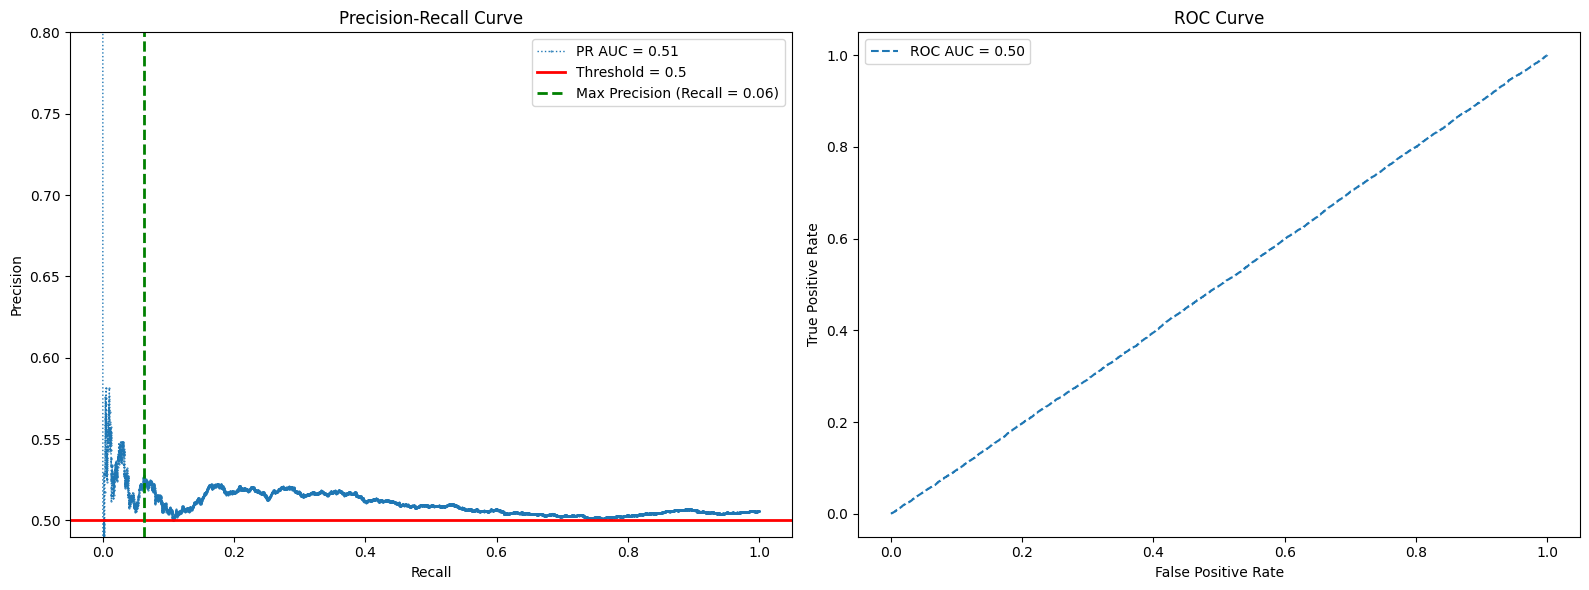

In [32]:
# Визуализация
plt.figure(figsize=(16, 6))

# Subplot 1: Precision-Recall Curve
plt.subplot(1, 2, 1)
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.2f}", marker='o', markersize=0.5, linestyle = ':', linewidth=1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim(0.49, 0.8)
plt.axhline(y=0.5, color='r', linestyle='-', linewidth=2, label="Threshold = 0.5")  # Horizontal line at y=0.5
plt.axvline(x=recall_at_max_precision, color='g', linestyle='--', linewidth=2, label=f"Max Precision (Recall = {recall_at_max_precision:.2f})")  # Vertical line at max precision
plt.title("Precision-Recall Curve")
plt.legend()

# Subplot 2: ROC Curve
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_train, y_train_pred_proba)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}", linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

# Заключение

В работе было произведено 2 эксперимента по моделированию, а также подготовка данных и генерация признаков, Dataset и dataloader.

Результаты представлены ниже, в таблице:

|  Модель      | Num of params | best Accuracy | 
| ---------------- |  ---------- |  -- | 
| LSTM based            |  223_361  | 0.515 | 
| Transformer based               |  2_373_121    | 0.528 |

Из полученных метрик можно сделать вывод о том, что обе модели могут быть использованы в криптотрейдинге, ведь точность их превышает 0.5. Однако, Transformer based показывает чуть лучшие результаты, однако колличество параметров, а следовательно длительность инференса у Transformer based выше.

Дальнейшее развитие проект может получить в улучшении метрик на обучении и генерации новых признаков.